# Data Load

In [76]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# print(x_train.shape)
x_train = np.expand_dims(np.resize(x_train, (x_train.shape[0], 32, 32)), axis=-1)
x_test = np.expand_dims(np.resize(x_test, (x_test.shape[0], 32, 32)), axis=-1)

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Set pretrained model

In [87]:
from keras.applications import ResNet50
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model

input_tensor = Input(shape=(32, 32, 3))
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
preds = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# # 기본 모델의 가중치 고정
# for layer in base_model.layers:
#     layer.trainable = False

# 특정 층부터 학습 가능하게 설정
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
# model.summary()

# Model Compile

In [88]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model fit

In [90]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

# 흑백 이미지를 3채널로 변경
x_train_rgb = np.concatenate([x_train, x_train, x_train], axis=-1)
x_test_rgb = np.concatenate([x_test, x_test, x_test], axis=-1)

# 모델 훈련
model.fit(
    datagen.flow(x_train_rgb, y_train, batch_size=128),
    validation_data=(x_test_rgb, y_test),
    steps_per_epoch=len(x_train) // 128,
    epochs=10
)

Epoch 1/10


2024-06-01 20:15:31.334443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 31/468 [>.............................] - ETA: 8:37 - loss: 2.3722 - accuracy: 0.1106

KeyboardInterrupt: 

# Preprocess

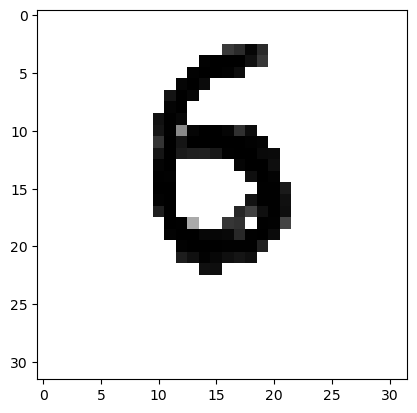

In [85]:
import matplotlib.pyplot as plt
import cv2 as cv

def preprocess_image(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32))
    img = img.astype('float32')
    img = img.reshape(32, 32, 1)
    # img = 255 - img
    img /= 255.0
    img = np.concatenate([img, img, img], axis=-1)  # 3채널로 변환
    img = img.reshape(1, 32, 32, 3)

    return img

img_path = 'handwriting/6.png'
image = preprocess_image(img_path)  # 전처리된 이미지 얻기

plt.imshow(image.reshape(32, 32, 3))
plt.show()

# Predict

In [86]:
import tensorflow as tf

@tf.function
def predict_image(model, image):
    return model(image)  # model.predict가 아니라 model(image)를 호출

pred = predict_image(model, image)  # 전처리된 이미지를 모델에 전달하여 예측
print(pred)
print(f'predicted number = {pred.numpy().argmax()}')

tf.Tensor(
[[1.4508456e-02 5.6232023e-01 1.0154590e-01 3.3823490e-02 1.0828131e-03
  3.9525967e-02 1.1630969e-01 9.7853437e-02 3.2523800e-02 5.0632231e-04]], shape=(1, 10), dtype=float32)
predicted number = 1
